In [1]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2024-12-18 12:37:13--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2024-12-18 12:37:14--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  21.6MB/s    in 39s     

2024-12-18 12:37:55 (19.4 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2024-12-18 12:37:55--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.r

In [2]:
!ls annotations

list.txt  README  test.txt  trainval.txt  trimaps  xmls


In [3]:
import os
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
import random
from keras import backend as K

In [4]:
input_dir = 'images/'
target_dir = 'annotations/trimaps/'
img_size = (160, 160)
num_classes = 3
batch_size = 10

# Create sorted lists of file paths for images and masks
input_img_paths = sorted(
    [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")]
)
target_img_paths = sorted(
    [os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")]
)

print(f"Number of images: {len(input_img_paths)}")
print(f"Number of masks: {len(target_img_paths)}")

Number of images: 7390
Number of masks: 7390


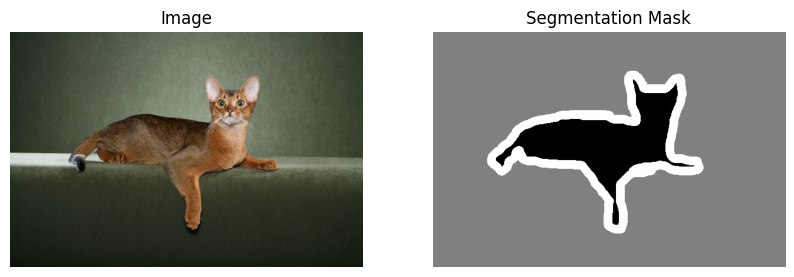

In [5]:
# Load a sample image and its corresponding mask
example_img_path = input_img_paths[0]
example_mask_path = target_img_paths[0]

# Read the image and mask
example_img = mpimg.imread(example_img_path)
example_mask = mpimg.imread(example_mask_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(example_img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Segmentation Mask")
plt.imshow(example_mask, cmap="gray")
plt.axis("off")

plt.show()

In [6]:
class DataGen(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
      self.batch_size=batch_size
      self.img_size=img_size
      self.input_img_paths=input_img_paths
      self.target_img_paths=target_img_paths

    def __len__(self):
      return len(self.target_img_paths)//self.batch_size

    def __getitem__(self, idx):
      i = idx * self.batch_size
      batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
      batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
      x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
      for j, path in enumerate(batch_input_img_paths):
          img = load_img(path, target_size=self.img_size)
          x[j] = img
      y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
      for j, path in enumerate(batch_target_img_paths):
          img = load_img(path, target_size=self.img_size, color_mode="grayscale")
          y[j] = np.expand_dims(img, 2)
          # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
          y[j] -= 1
      return x, y


In [7]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.4)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.4)(x)
    x = double_conv_block(x, n_filters)
    return x

In [8]:
def get_model(img_size, num_classes):
    inputs = layers.Input(shape=(*img_size, 3))
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    bottleneck = double_conv_block(p4, 1024)
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(u9)
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model
keras.backend.clear_session()
model = get_model(img_size, num_classes)
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 160, 160, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 160, 160, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 80, 80, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 80, 80, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 80, 80, 128)    │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 80, 80, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 40, 40, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 40, 40, 128)    │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 40, 40, 256)    │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 40, 40, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 20, 20, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 20, 20, 256)    │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 20, 20, 512)    │      1,180,160 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 20, 20, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 10, 10, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 10, 10, 512)    │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
val_samples = 1000
random.Random(1500).shuffle(input_img_paths)
random.Random(1500).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]


train_gen = DataGen(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = DataGen(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [10]:
# Dice coefficient
def dice_coefficient(y_true, y_pred):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)  # One-hot encoding
    y_true = tf.reshape(y_true, (-1, num_classes))  # Reshape to 2D tensor
    y_pred = tf.reshape(y_pred, (-1, num_classes))  # Reshape to 2D tensor

    y_pred = tf.nn.softmax(y_pred)  # Apply softmax to predictions
    y_pred = tf.round(y_pred)  # Convert probabilities to binary 0/1

    intersection = tf.reduce_sum(y_true * y_pred)  # True positives
    denominator = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)  # True + False

    dice = (2.0 * intersection + 1e-7) / (denominator + 1e-7)  # Smooth to avoid division by zero
    return dice

In [11]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", dice_coefficient]
)

callbacks = [
    keras.callbacks.ModelCheckpoint("unet.keras", save_best_only=True)
]

epochs = 10

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=callbacks
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


639/639 ━━━━━━━━━━━━━━━━━━━━ 230s 287ms/step - accuracy: 0.5818 - dice_coefficient: 0.2227 - loss: 1.5542 - val_accuracy: 0.7315 - val_dice_coefficient: 0.3882 - val_loss: 0.6637
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 181s 282ms/step - accuracy: 0.7257 - dice_coefficient: 0.4914 - loss: 0.6904 - val_accuracy: 0.7612 - val_dice_coefficient: 0.5202 - val_loss: 0.6129
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 202s 282ms/step - accuracy: 0.7635 - dice_coefficient: 0.5977 - loss: 0.6149 - val_accuracy: 0.8008 - val_dice_coefficient: 0.6981 - val_loss: 0.5153
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 181s 284ms/step - accuracy: 0.7917 - dice_coefficient: 0.6599 - loss: 0.5481 - val_accuracy: 0.8117 - val_dice_coefficient: 0.7412 - val_loss: 0.4854
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 194s 272ms/step - accuracy: 0.8144 - dice_coefficient: 0.7047 - loss: 0.4991 - val_accuracy: 0.7993 - val_dice_coefficient: 0.7078 - val_loss: 0.5320
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 207s 281ms/step - acc

In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'dice_coefficient', 'loss', 'val_accuracy', 'val_dice_coefficient', 'val_loss'])

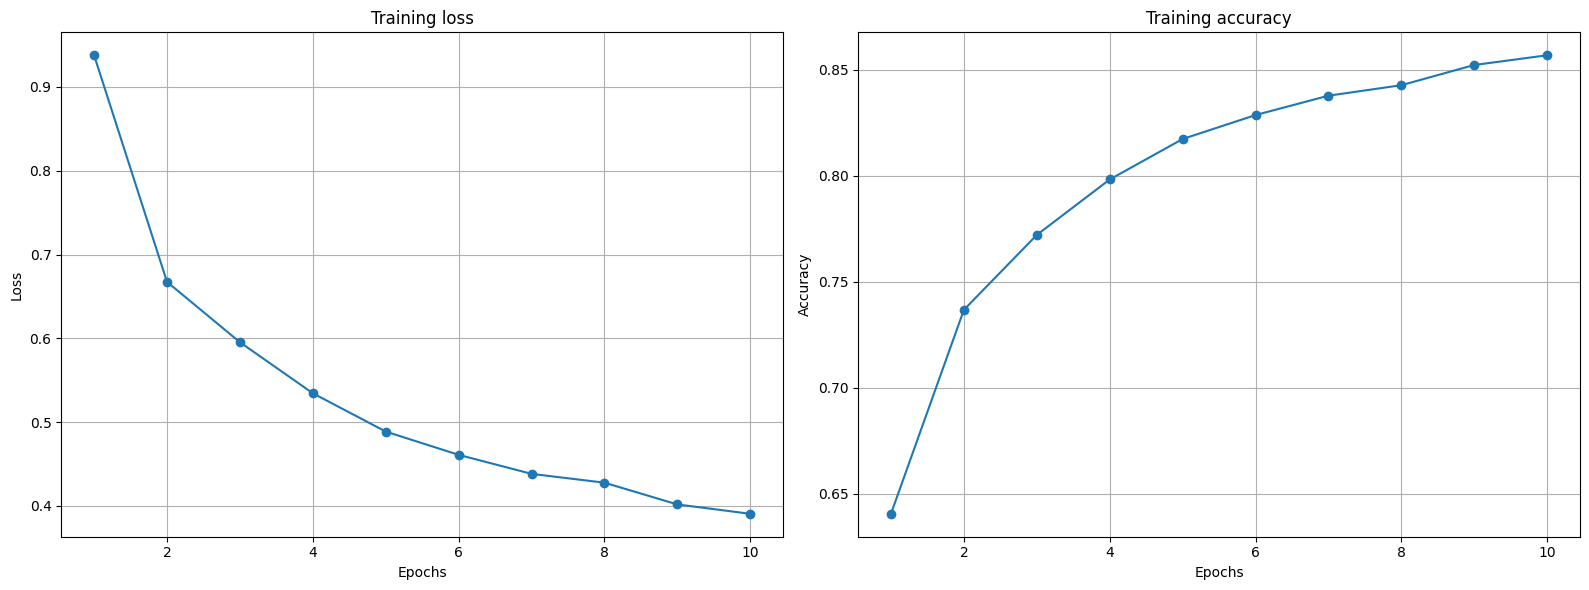

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
epochs = range(1, len(history_dict['accuracy']) + 1)

ax1.plot(epochs, history_dict['loss'], '-o')
ax1.set_title('Training loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True)

ax2.plot(epochs, history_dict['accuracy'], '-o')
ax2.set_title('Training accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid(True)

plt.tight_layout()
plt.show()
